# Causal Modelling with DoWhy and EconML

# Imports

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel, plotter
from IPython.display import Image, display
import matplotlib

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import econml

# Read data

In [2]:
df = pd.read_csv('../data/causal_df.csv')

In [3]:
df.head()

,Unnamed: 0,date,day_of_week,weather_region_cd,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month
0,0,2022-03-27,0.0,1.0,15.4,0.2,12.1,2.704702,1498.0,6.2,3.0
1,1,2022-03-27,0.0,10.0,12.7,0.0,10.6,2.704702,2285.0,6.2,3.0
2,2,2022-03-27,0.0,11.0,15.1,0.0,10.2,2.704702,5509.0,6.2,3.0
3,3,2022-03-27,0.0,12.0,10.7,0.0,5.3,2.704702,7776.0,6.2,3.0
4,4,2022-03-27,0.0,13.0,13.1,0.0,8.6,2.704702,4903.0,6.2,3.0


# Creating Causal Graph

In [4]:
causal_graph = """
digraph {

weather_region_cd;
maximum_feels_like_temperature;
avg_ice_cream_price;
ice_cream_sold;
U[label="Unobserved Confounders"];

weather_region_cd->maximum_feels_like_temperature;
weather_region_cd->avg_ice_cream_price;

month->maximum_feels_like_temperature;

U->ice_cream_sold;
avg_ice_cream_price->ice_cream_sold; 
maximum_feels_like_temperature->ice_cream_sold;
weather_region_cd->ice_cream_sold;
month->ice_cream_sold;
}
"""

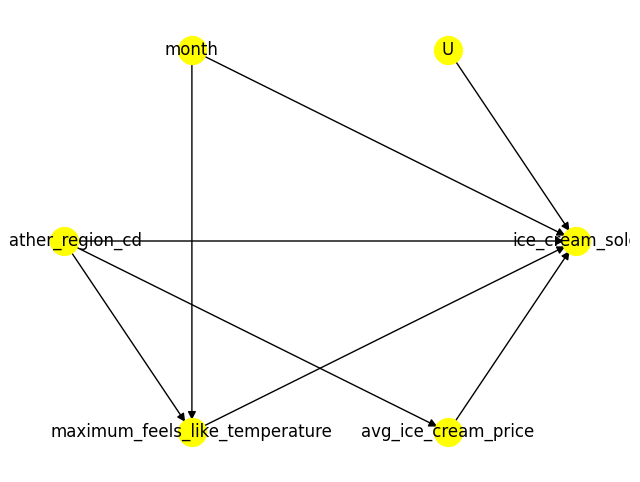

In [5]:
model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='maximum_feels_like_temperature',
        outcome='ice_cream_sold'
        )

model.view_model()

# Identify Causal Effects

In [24]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                           
─────────────────────────────────(E[ice_cream_sold|weather_region_cd,month])
d[maximum_feels_like_temperature]                                           
Estimand assumption 1, Unconfoundedness: If U→{maximum_feels_like_temperature} and U→ice_cream_sold then P(ice_cream_sold|maximum_feels_like_temperature,weather_region_cd,month,U) = P(ice_cream_sold|maximum_feels_like_temperature,weather_region_cd,month)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimate Causal Effects

In [66]:
#Causal Effect Estimation

controls = []
values = []

for control in range(0, 35, 5):

    estimate = model.estimate_effect(estimands,method_name="backdoor.econml.dml.CausalForestDML",
                                        method_params={
                                            'init_params': {'model_y':LassoCV(),
                                                            'model_t': LassoCV()},
                                            'fit_params': {}
                                        }, confidence_intervals=False, test_significance=False,
                                        control_value=control, treatment_value=control+1)

    controls.append(control)
    values.append(estimate.value)

dict_effects = {}
dict_effects['temp'] = controls
dict_effects['effects'] = values

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [67]:
df_effects = pd.DataFrame.from_dict(dict_effects)

<Axes: xlabel='temp'>

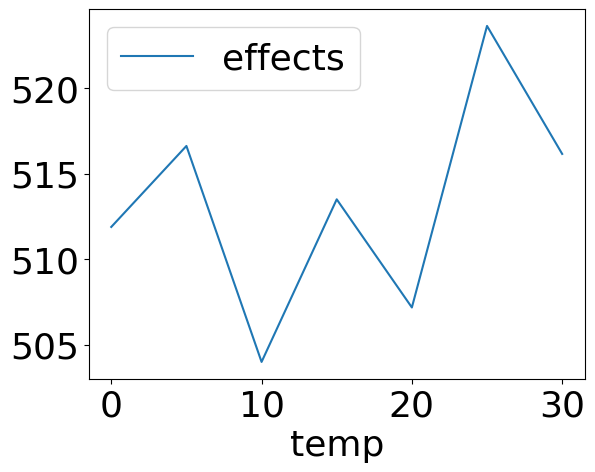

In [68]:
df_effects.plot(x='temp', y='effects')

# Refutes

In [12]:
refutel_random_common_cause = model.refute_estimate(estimands,estimate, "random_common_cause")
refutel_placebo_treatment_refuter = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
refutel_data_subset_refuter = model.refute_estimate(estimands,estimate, "data_subset_refuter")
res_unobserved_range = model.refute_estimate(estimands, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02],
                                           effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02])


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [13]:
print(refutel_random_common_cause)

Refute: Add a random common cause
Estimated effect:390.53098679798666
New effect:384.79646617998355
p value:0.24



In [14]:
print(refutel_placebo_treatment_refuter)

Refute: Use a Placebo Treatment
Estimated effect:390.53098679798666
New effect:0.0
p value:1.0



In [15]:
print(refutel_data_subset_refuter)

Refute: Use a subset of data
Estimated effect:390.53098679798666
New effect:388.35401356278015
p value:0.43000000000000005



In [19]:
print(res_unobserved_range)

Refute: Add an Unobserved Common Cause
Estimated effect:390.53098679798666
New effect:(46.938898953428186, 381.6304833049721)



# Final Estimates